# Prepare FFDI and DI data from raw forecast/historical data and save intermediate files for further processing

### Time taken: ~ 1.5 hours

------

In [1]:
import glob

import cftime

import numpy as np
import xarray as xr

import myfuncs as my

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
from dask_jobqueue import PBSCluster

In [18]:
walltime = '02:00:00'
cores = 48
memory = '192GB'
cluster = PBSCluster(processes=4,
                     walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
                     header_skip=["select"])

In [19]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.6.77.10:8787/status,
Dashboard: http://10.6.77.10:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.77.10:41821,Workers: 0
Dashboard: http://10.6.77.10:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


--------
# Parameters

In [2]:
REGION_MASK = xr.open_dataset('./data/region_mask.ONDJF.10.nc')['region_mask']
AUSTRALIA_MASK_jragrid = xr.open_dataset('./data/Aus_mask.jra_grid.nc')['australia_mask']
AUSTRALIA_MASK_awapgrid = xr.open_dataset('./data/Aus_mask.awap_grid.nc')['australia_mask']
AUSTRALIA_MASK_cafegrid = xr.open_dataset('./data/Aus_mask.cafe_grid.nc')['australia_mask']

cafe_area = my.open_zarr(
    '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20201101/atmos_isobaric_daily.zarr.zip',
    preprocess=my.truncate_latitudes)['area']

clobber = False # If False, read intermediate datasets from disk if they exist

--------
# Prepare JRA-55 data on cafe grid over Australia and our region

In [3]:
data_path = '/g/data/xv83/reanalyses/JRA55'

In [6]:
jra_sfc_variables = {'TPRAT_GDS0_SFC': 'precip',
                     'TMAX_GDS4_HTGL': 't_ref_max',
                     'UGRD_GDS0_HTGL': 'u_ref',
                     'VGRD_GDS0_HTGL': 'v_ref'}

jra_sfc = my.open_zarr(
    f'{data_path}/surface_daily_cafe-grid.zarr', 
    variables=jra_sfc_variables.keys(),
    region=AUSTRALIA_MASK_cafegrid,
    preprocess=my.truncate_latitudes).rename(
    {**jra_sfc_variables, 'initial_time0_hours': 'time'})

jra_iso_variables = {'RH_GDS0_ISBL': 'rh'}

jra_iso = my.open_zarr(
    f'{data_path}/isobaric_daily_cafe-grid.zarr', 
    variables=jra_iso_variables.keys(),
    region=AUSTRALIA_MASK_cafegrid,
    preprocess=my.truncate_latitudes).rename(
    {**jra_iso_variables, 'initial_time0_hours': 'time'})

### Process precip

In [7]:
jra_precip = jra_sfc['precip']
jra_precip = jra_precip.chunk({'time':-1})
jra_precip = my.to_zarr(
    jra_precip, f'data/JRA-55_precip_cafegrid.zarr', clobber=clobber)

jra_precip_20d = jra_precip.rolling(time=20).sum().rename('precip_20d')
jra_precip_20d = jra_precip_20d.chunk({'time':-1})
jra_precip_20d = my.to_zarr(
    jra_precip_20d, f'data/JRA-55_precip-20d-accl_cafegrid.zarr', clobber=clobber)

jra_df = my.calc_drought_factor(jra_precip_20d, dim='time').rename('drought_factor')
jra_df = jra_df.chunk({'time':-1})
jra_df = my.to_zarr(
    jra_df, f'data/JRA-55_drought-factor_cafegrid.zarr', clobber=clobber)

### Process t_ref_max

In [8]:
jra_tmax = jra_sfc['t_ref_max'] - 273.15 # [C]
jra_tmax = jra_tmax.chunk({'time':-1})
jra_tmax = my.to_zarr(
    jra_tmax, f'data/JRA-55_tmax_cafegrid.zarr', clobber=clobber)

### Process V_ref

In [9]:
jra_uref = jra_sfc['u_ref'] * 3.6 # [km/h]
jra_vref = jra_sfc['v_ref'] * 3.6 # [km/h]
jra_Vref = np.sqrt(jra_uref ** 2 + jra_vref ** 2).rename('V_ref')
jra_Vref = jra_Vref.chunk({'time':-1})
jra_Vref = my.to_zarr(
    jra_Vref, f'data/JRA-55_Vref_cafegrid.zarr', clobber=clobber)

## Process rh

In [10]:
jra_rh = jra_iso['rh'].sel(lv_ISBL1=1000.)
jra_rh = jra_rh.chunk({'time':-1})
jra_rh = my.to_zarr(
    jra_rh, f'data/JRA-55_rh_cafegrid.zarr', clobber=clobber)

## Process FFDI

In [11]:
jra_FFDI = my.calc_FFDI(jra_df, jra_tmax, jra_rh, jra_Vref)
jra_FFDI = jra_FFDI.chunk({'time':-1})
jra_FFDI = my.to_zarr(
    jra_FFDI, f'data/JRA-55_FFDI_cafegrid.zarr', clobber=clobber)

jra_FFDI_DEC = my.calc_DEC_average(jra_FFDI).rename('FFDI_DEC')
jra_FFDI_DEC = my.to_zarr(
    jra_FFDI_DEC, f'data/JRA-55_FFDI-DEC-mean_cafegrid.zarr', clobber=clobber)

jra_FFDI_DEC_reg = jra_FFDI_DEC.where(
    REGION_MASK, drop=True).weighted(cafe_area).mean(['lat','lon'])
jra_FFDI_DEC_reg = my.to_zarr(
    jra_FFDI_DEC_reg, f'data/JRA-55_FFDI-DEC-mean_region.zarr', clobber=clobber)

--------
# Prepare JRA-55 data on native grid over Australia

In [4]:
data_path = '/g/data/xv83/reanalyses/JRA55'

In [5]:
def preprocess(ds):
    def _rename_lat_lon(da):
        if 'g0_lon_2' in da.dims:
            return da.rename({'g0_lon_2':'lon', 'g0_lat_1': 'lat'})
        elif 'g0_lon_3' in da.dims:
            return da.rename({'g0_lon_3':'lon', 'g0_lat_2': 'lat'})
        else: return da

    return ds.apply(_rename_lat_lon)

jra_sfc_variables = {'TPRAT_GDS0_SFC': 'precip',
                     'TMAX_GDS4_HTGL': 't_ref_max',
                     'UGRD_GDS0_HTGL': 'u_ref',
                     'VGRD_GDS0_HTGL': 'v_ref'}

jra_sfc = my.open_zarr(
    f'{data_path}/surface_daily.zarr', 
    variables=jra_sfc_variables.keys(),
    region=AUSTRALIA_MASK_jragrid,
    preprocess=preprocess).rename(
    {**jra_sfc_variables, 'initial_time0_hours': 'time'})

jra_iso_variables = {'RH_GDS0_ISBL': 'rh'}

jra_iso = my.open_zarr(
    f'{data_path}/isobaric_daily.zarr', 
    variables=jra_iso_variables.keys(),
    region=AUSTRALIA_MASK_jragrid,
    preprocess=preprocess).rename(
    {**jra_iso_variables, 'initial_time0_hours': 'time'})

### Process precip

In [6]:
jra_precip = jra_sfc['precip']
jra_precip = jra_precip.chunk({'time':-1})
jra_precip = my.to_zarr(
    jra_precip, f'data/JRA-55_precip_jragrid.zarr', clobber=clobber)

jra_precip_20d = jra_precip.rolling(time=20).sum().rename('precip_20d')
jra_precip_20d = jra_precip_20d.chunk({'time':-1})
jra_precip_20d = my.to_zarr(
    jra_precip_20d, f'data/JRA-55_precip-20d-accl_jragrid.zarr', clobber=clobber)

jra_df = my.calc_drought_factor(jra_precip_20d, dim='time').rename('drought_factor')
jra_df = jra_df.chunk({'time':-1})
jra_df = my.to_zarr(
    jra_df, f'data/JRA-55_drought-factor_jragrid.zarr', clobber=clobber)

### Process t_ref_max

In [7]:
jra_tmax = jra_sfc['t_ref_max'] - 273.15 # [C]
jra_tmax = jra_tmax.chunk({'time':-1})
jra_tmax = my.to_zarr(
    jra_tmax, f'data/JRA-55_tmax_jragrid.zarr', clobber=clobber)

### Process V_ref

In [8]:
jra_uref = jra_sfc['u_ref'] * 3.6 # [km/h]
jra_vref = jra_sfc['v_ref'] * 3.6 # [km/h]
jra_Vref = np.sqrt(jra_uref ** 2 + jra_vref ** 2).rename('V_ref')
jra_Vref = jra_Vref.chunk({'time':-1})
jra_Vref = my.to_zarr(
    jra_Vref, f'data/JRA-55_Vref_jragrid.zarr', clobber=clobber)

## Process rh

In [9]:
jra_rh = jra_iso['rh'].sel(lv_ISBL1=1000.)
jra_rh = jra_rh.chunk({'time':-1})
jra_rh = my.to_zarr(
    jra_rh, f'data/JRA-55_rh_jragrid.zarr', clobber=clobber)

## Process FFDI

In [10]:
jra_FFDI = my.calc_FFDI(jra_df, jra_tmax, jra_rh, jra_Vref)
jra_FFDI = jra_FFDI.chunk({'time':-1})
jra_FFDI = my.to_zarr(
    jra_FFDI, f'data/JRA-55_FFDI_jragrid.zarr', clobber=clobber)

jra_FFDI_DEC = my.calc_DEC_average(jra_FFDI).rename('FFDI_DEC')
jra_FFDI_DEC = my.to_zarr(
    jra_FFDI_DEC, f'data/JRA-55_FFDI-DEC-mean_jragrid.zarr', clobber=clobber)

## Figure for reviewer: delete me

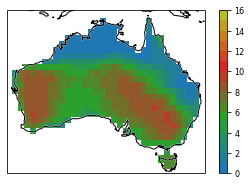

In [199]:
import cartopy
import cartopy.crs as ccrs

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["C0"]+["C2"]+["C3"]+["C8"])

cartopy.config['pre_existing_data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'

period = slice(None, '2016')

jra_FFDI_period = jra_FFDI.sel(time=period)

p90 = jra_FFDI_period.quantile(q=0.9, dim='time').compute()
gt_p90_Dec = jra_FFDI_period.where(jra_FFDI_period.time.dt.month == 12, drop=True) > p90
n_days_gt_p90_Dec = 31*gt_p90_Dec.mean('time').where(AUSTRALIA_MASK_jragrid)

figsize = (5,3)

fig = plt.figure(figsize=figsize, edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))
    
p = n_days_gt_p90_Dec.plot(levels=17, transform=ccrs.PlateCarree(), 
                           cmap=cmap, vmin=0, vmax=16, add_colorbar=False)

p.axes.coastlines(color='w', linewidth=1.5)
p.axes.coastlines(color='k', linewidth=1)

region = [112, 154.5, -44, -9]
ax.set_extent(region, ccrs.PlateCarree())
ax.set_title('')

cbar = fig.colorbar(p, ticks=range(0,18,2))
cbar.ax.set_yticklabels(range(0,18,2), fontsize=8);

fig.savefig(f'./figures/n_Dec_days_gt_p90.pdf', format='pdf', 
            bbox_inches='tight')

--------
# Prepare AWAP data on cafe grid over Australia and our region

In [20]:
data_path = '/g/data/xv83/observations/AWAP'

In [21]:
awap_precip = my.open_zarr(
    f'{data_path}/rain_day_19000101-20210425_cafe-grid.zarr', 
    variables=['precip'],
    region=AUSTRALIA_MASK_cafegrid,
    preprocess=my.truncate_latitudes)['precip']
awap_precip = awap_precip.chunk({'time':-1})
awap_precip = my.to_zarr(
    awap_precip, f'data/AWAP_precip_cafegrid.zarr', clobber=clobber)

awap_precip_ann = my.calc_ANN_accum(awap_precip).rename('precip_ann')
awap_precip_ann = awap_precip_ann.chunk({'time':-1})
awap_precip_ann = my.to_zarr(
    awap_precip_ann, f'data/AWAP_precip-annDEC-accl_cafegrid.zarr', clobber=clobber)

awap_precip_ann_reg = awap_precip_ann.where(
    REGION_MASK, drop=True).weighted(cafe_area).mean(['lat','lon'])
awap_precip_ann_reg = my.to_zarr(
    awap_precip_ann_reg, f'data/AWAP_precip-annDEC-accl_region.zarr', clobber=clobber)

--------
# Prepare AWAP data on JRA-55 grid over Australia

In [23]:
data_path = '/g/data/xv83/observations/AWAP'

In [24]:
awap_precip = my.open_zarr(
    f'{data_path}/rain_day_19000101-20210425_jra-grid.zarr', 
    variables=['precip'],
    region=AUSTRALIA_MASK_jragrid)['precip']
awap_precip = awap_precip.chunk({'time': 365})
awap_precip = my.to_zarr(
    awap_precip, f'data/AWAP_precip_jragrid.zarr', clobber=clobber)

awap_precip_ann = my.calc_ANN_accum(awap_precip).rename('precip_ann')
awap_precip_ann = awap_precip_ann.chunk({'time':-1})
awap_precip_ann = my.to_zarr(
    awap_precip_ann, f'data/AWAP_precip-annDEC-accl_jragrid.zarr', clobber=clobber)

--------
# Prepare AWAP data on native grid over Australia

In [25]:
data_path = '/g/data/xv83/observations/AWAP'

In [26]:
awap_precip = my.open_zarr(
    f'{data_path}/rain_day_19000101-20210425.zarr', 
    variables=['precip'],
    region=AUSTRALIA_MASK_awapgrid)['precip']
awap_precip = my.to_zarr(
    awap_precip, f'data/AWAP_precip_awapgrid.zarr', clobber=clobber)

awap_precip_ann = my.calc_ANN_accum(awap_precip).rename('precip_ann')
awap_precip_ann = awap_precip_ann.chunk({'time':-1})
awap_precip_ann = my.to_zarr(
    awap_precip_ann, f'data/AWAP_precip-annDEC-accl_awapgrid.zarr', clobber=clobber)

--------
# Prepare CAFE-f6 forecast data

In [5]:
fcst_paths = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6*/atmos_isobaric_daily.zarr.zip')
)[-32:]

In [6]:
fcst_paths

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20050501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20051101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20060501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20061101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20070501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20071101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20080501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20081101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20090501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20091101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20100501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20101101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/d

In [7]:
def preprocess(ds):
    return my.truncate_latitudes(ds).sel({'level': 1000.0})

fcst_variables = ['precip', 't_ref_max', 'u_ref', 'v_ref', 'rh']

f6_stacked = my.open_zarr_forecasts(
    fcst_paths,
    variables=fcst_variables,
    region=REGION_MASK,
    preprocess=preprocess)

# Fill nans in time that come about due to leap years
f6_stacked = my.interpolate_na_times(f6_stacked)

f6_stacked = f6_stacked.chunk({'init_date':-1, 'lead_time': -1})

### Process precip

In [10]:
f6_precip_stacked = f6_stacked['precip'] * 86400
f6_precip_stacked = my.to_zarr(
    f6_precip_stacked, f'data/CAFE-f6_precip-stacked.zarr', clobber=clobber)

f6_precip_20d_stacked = f6_precip_stacked.rolling(
    lead_time=20).sum().rename('precip_20d').chunk(f6_precip_stacked.chunks)
f6_precip_20d_stacked = my.to_zarr(
    f6_precip_20d_stacked, f'data/CAFE-f6_precip-20d-accl-stacked.zarr', clobber=clobber)

f6_df_stacked = my.calc_drought_factor(
    f6_precip_20d_stacked, 
    dim=['init_date', 'lead_time','ensemble']).rename('drought_factor')
f6_df_stacked = my.to_zarr(
    f6_df_stacked, f'data/CAFE-f6_drought-factor-stacked.zarr', clobber=clobber)

f6_precip = my.reindex_forecast(f6_precip_stacked)
f6_precip_ann = my.calc_ANN_accum(f6_precip).rename('precip_ann')
f6_precip_ann = f6_precip_ann.chunk({'init_date':-1, 'time': -1})
f6_precip_ann = my.to_zarr(
    f6_precip_ann, f'data/CAFE-f6_precip-annDEC-accl.zarr', clobber=clobber)

f6_precip_ann_reg = f6_precip_ann.weighted(cafe_area).mean(['lat','lon'])
f6_precip_ann_reg = my.to_zarr(
    f6_precip_ann_reg, f'data/CAFE-f6_precip-annDEC-accl_region.zarr', clobber=clobber)

### Process t_ref_max

In [12]:
f6_tmax_stacked = f6_stacked['t_ref_max'] - 273.15 # [C]
f6_tmax_stacked = my.to_zarr(
    f6_tmax_stacked, f'data/CAFE-f6_tmax-stacked.zarr', clobber=clobber)

### Process V_ref

In [13]:
f6_uref_stacked = f6_stacked['u_ref'] * 3.6 # [km/h]
f6_uref_stacked = my.to_zarr(
    f6_uref_stacked, f'data/CAFE-f6_uref-stacked.zarr', clobber=clobber)

f6_vref_stacked = f6_stacked['v_ref'] * 3.6 # [km/h]
f6_vref_stacked = my.to_zarr(
    f6_vref_stacked, f'data/CAFE-f6_vref-stacked.zarr', clobber=clobber)

f6_Vref_stacked = np.sqrt( f6_uref_stacked ** 2 + f6_vref_stacked ** 2 ).rename('V_ref')
f6_Vref_stacked = my.to_zarr(
    f6_Vref_stacked, f'data/CAFE-f6_Vref-stacked.zarr', clobber=clobber)

### Process rh

In [20]:
f6_rh_stacked = f6_stacked['rh'] # [%]
f6_rh_stacked = my.to_zarr(
    f6_rh_stacked, f'data/CAFE-f6_rh-stacked.zarr', clobber=clobber)

### Process FFDI

In [21]:
f6_FFDI_stacked = my.calc_FFDI(f6_df_stacked, f6_tmax_stacked, f6_rh_stacked, f6_Vref_stacked)
f6_FFDI = my.reindex_forecast(f6_FFDI_stacked)
f6_FFDI = f6_FFDI.chunk({'init_date': 5, 'time': -1})
f6_FFDI = my.to_zarr(
    f6_FFDI, f'data/CAFE-f6_FFDI.zarr', clobber=clobber)

f6_FFDI_DEC = my.calc_DEC_average(f6_FFDI).rename('FFDI_DEC')
f6_FFDI_DEC = f6_FFDI_DEC.chunk({'init_date': -1, 'time': -1})
f6_FFDI_DEC = my.to_zarr(
    f6_FFDI_DEC, f'data/CAFE-f6_FFDI-DEC-mean.zarr', clobber=clobber)

f6_FFDI_DEC_reg = f6_FFDI_DEC.weighted(cafe_area).mean(['lat','lon'])
f6_FFDI_DEC_reg = my.to_zarr(
    f6_FFDI_DEC_reg, f'data/CAFE-f6_FFDI-DEC-mean_region.zarr', clobber=clobber)

--------
# Prepare CAFE-f5 forecast data

In [38]:
fcst_paths_MAY = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f5/MAY/c5-d60-pX-f5*/atmos_isobaric_daily.zarr.zip')
)
fcst_path_NOV = '/g/data/xv83/dcfp/CAFE-f5/NOV/atmos_isobaric_daily.zarr.zip'

In [39]:
def preprocess(ds):
    return my.truncate_latitudes(ds).sel({'level': 1000.0})

fcst_variables = ['precip', 't_ref_max', 'u_ref', 'v_ref', 'rh']

f5_MAY_stacked = my.open_zarr_forecasts(
    fcst_paths_MAY,
    variables=fcst_variables,
    region=REGION_MASK,
    preprocess=preprocess,
    convert_time_to_lead=True)

f5_NOV_stacked = my.open_zarr(
    fcst_path_NOV, 
    variables=fcst_variables,
    region=REGION_MASK,
    preprocess=preprocess)

f6_append = f6_stacked.sel(
    init_date=slice('2005', None), 
    ensemble=range(1,11))

f5_stacked = xr.concat(
    [f5_MAY_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}), 
     f5_NOV_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}),
     f6_append.chunk({'init_date': -1})], # Dask keeps hanging on the last few tasks. Playing with chunking here helps
    dim='init_date', coords='minimal', compat='override').sortby('init_date')

# Fill nans in time that come about due to leap years
f5_stacked = my.interpolate_na_times(f5_stacked)

f5_stacked = f5_stacked.chunk({'init_date':-1, 'lead_time': -1})

### Process precip

In [40]:
f5_precip_stacked = f5_stacked['precip'] * 86400
f5_precip_stacked = my.to_zarr(
    f5_precip_stacked, f'data/CAFE-f5_precip.zarr', clobber=clobber)

f5_precip_20d_stacked = f5_precip_stacked.rolling(
    lead_time=20).sum().rename('precip_20d').chunk(f5_precip_stacked.chunks)
f5_precip_20d_stacked = my.to_zarr(
    f5_precip_20d_stacked, f'data/CAFE-f5_precip-20d-accl-stacked.zarr', clobber=clobber)

f5_df_stacked = my.calc_drought_factor(
    f5_precip_20d_stacked, 
    dim=['init_date', 'lead_time','ensemble']).rename('drought_factor')
f5_df_stacked = my.to_zarr(
    f5_df_stacked, f'data/CAFE-f5_drought-factor-stacked.zarr', clobber=clobber)

f5_precip = my.reindex_forecast(f5_precip_stacked)
f5_precip_ann = my.calc_ANN_accum(f5_precip).rename('precip_ann')
f5_precip_ann = f5_precip_ann.chunk({'init_date':-1, 'time': -1})
f5_precip_ann = my.to_zarr(
    f5_precip_ann, f'data/CAFE-f5_precip-annDEC-accl.zarr', clobber=clobber)

f5_precip_ann_reg = f5_precip_ann.weighted(cafe_area).mean(['lat','lon'])
f5_precip_ann_reg = my.to_zarr(
    f5_precip_ann_reg, f'data/CAFE-f5_precip-annDEC-accl_region.zarr', clobber=clobber)

### Process t_ref_max

In [42]:
f5_tmax_stacked = f5_stacked['t_ref_max'] - 273.15 # [C]
f5_tmax_stacked = my.to_zarr(
    f5_tmax_stacked, f'data/CAFE-f5_tmax-stacked.zarr', clobber=clobber)

### Process V_ref

In [43]:
f5_uref_stacked = f5_stacked['u_ref'] * 3.6 # [km/h]
f5_uref_stacked = my.to_zarr(
    f5_uref_stacked, f'data/CAFE-f5_uref-stacked.zarr', clobber=clobber)

f5_vref_stacked = f5_stacked['v_ref'] * 3.6 # [km/h]
f5_vref_stacked = my.to_zarr(
    f5_vref_stacked, f'data/CAFE-f5_vref-stacked.zarr', clobber=clobber)

f5_Vref_stacked = np.sqrt( f5_uref_stacked ** 2 + f5_vref_stacked ** 2 ).rename('V_ref')
f5_Vref_stacked = my.to_zarr(
    f5_Vref_stacked, f'data/CAFE-f5_Vref-stacked.zarr', clobber=clobber)

### Process rh

In [44]:
f5_rh_stacked = f5_stacked['rh'] # [%]
f5_rh_stacked = my.to_zarr(
    f5_rh_stacked, f'data/CAFE-f5_rh-stacked.zarr', clobber=clobber)

### Process FFDI

In [45]:
f5_FFDI_stacked = my.calc_FFDI(f5_df_stacked, f5_tmax_stacked, f5_rh_stacked, f5_Vref_stacked)
f5_FFDI = my.reindex_forecast(f5_FFDI_stacked)
f5_FFDI = f5_FFDI.chunk({'init_date':10, 'time': -1})
f5_FFDI = my.to_zarr(
    f5_FFDI, f'data/CAFE-f5_FFDI.zarr', clobber=clobber)

f5_FFDI_DEC = my.calc_DEC_average(f5_FFDI).rename('FFDI_DEC')
f5_FFDI_DEC = f5_FFDI_DEC.chunk({'init_date':-1, 'time': -1})
f5_FFDI_DEC = my.to_zarr(
    f5_FFDI_DEC, f'data/CAFE-f5_FFDI-DEC-mean.zarr', clobber=clobber)

f5_FFDI_DEC_reg = f5_FFDI_DEC.weighted(cafe_area).mean(['lat','lon'])
f5_FFDI_DEC_reg = my.to_zarr(
    f5_FFDI_DEC_reg, f'data/CAFE-f5_FFDI-DEC-mean_region.zarr', clobber=clobber)

--------
# End notebook

In [47]:
cluster.close()
client.close()